In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'recipient'

time: 1.57 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 6.17 s


In [4]:
l_b = plurality(d_b[task].dropna())
l_r = plurality(d_r[task].dropna())

time: 6.36 s


In [5]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 259 ms


### Split into train/dev and test

In [6]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 18.2 ms


In [7]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 5.23 ms


In [8]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 6.97 ms


In [9]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

4

time: 10.8 ms


### NGram Classification Pipeline

In [10]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (15000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1.0,5,10),
    'clf__class_weight': ('balanced', None)
}

time: 3.93 ms


### Hyper-Parameter tuning

In [11]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 1.0} 0.926795122942


Grid scores:
0.92488 (+/-0.00103) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 1.0}
0.92680 (+/-0.00083) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 1.0}
0.92241 (+/-0.00168) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 5}
0.92500 (+/-0.00172) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 5}
0.91892 (+/-0.00189) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__class_weight': 'balanced', 'vect__max_features': 15000, 'clf__C': 10}
0.92189 (+/-0.00208) for

In [42]:
## Be very careful to reanscirbe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char')),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, class_weight = None)),
])

time: 5.66 ms


### Train on blocked

In [43]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 29.1 s


Eval on blocked


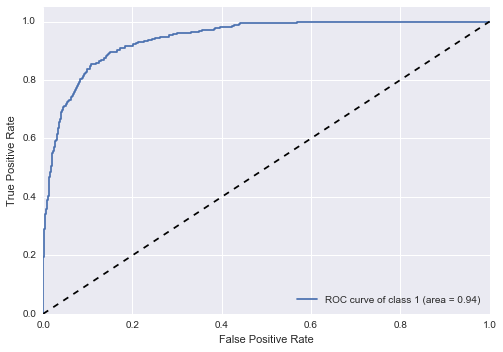


    Precision: 0.846
    Recall: 0.543
    F1: 0.661
    ROC: 0.943
    
time: 9.37 s


In [44]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


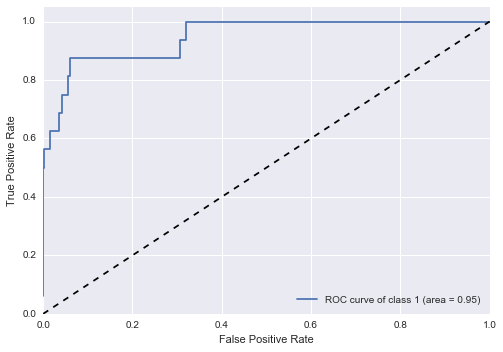


    Precision: 0.562
    Recall: 0.562
    F1: 0.562
    ROC: 0.948
    
time: 7.13 s


In [45]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [46]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 21.7 s


Eval on blocked


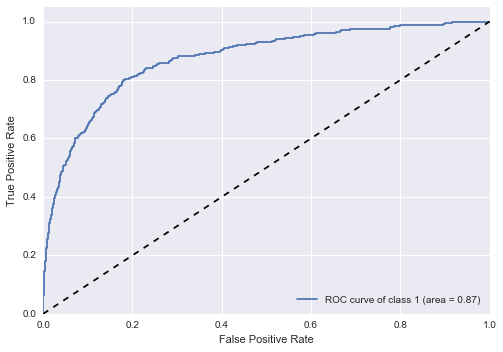


    Precision: 1.000
    Recall: 0.018
    F1: 0.035
    ROC: 0.874
    
time: 9.85 s


In [47]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


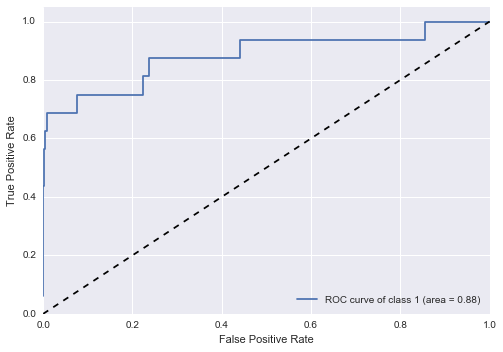


    Precision: 0.000
    Recall: 0.000
    F1: 0.000
    ROC: 0.884
    
time: 7.15 s


In [48]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [49]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 53.3 s


Eval on blocked


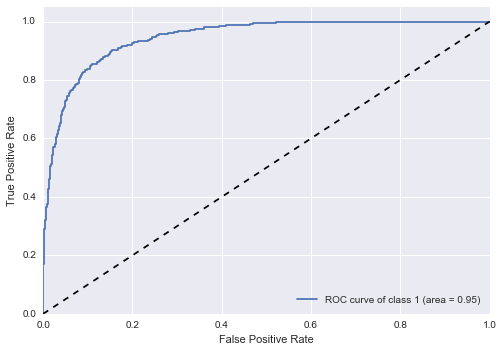


    Precision: 0.854
    Recall: 0.513
    F1: 0.641
    ROC: 0.946
    
time: 9.79 s


In [50]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


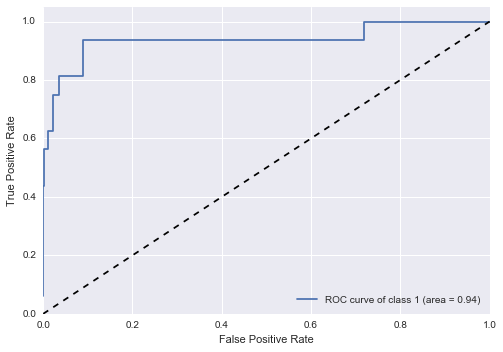


    Precision: 0.643
    Recall: 0.562
    F1: 0.600
    ROC: 0.938
    
time: 7.36 s


In [51]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


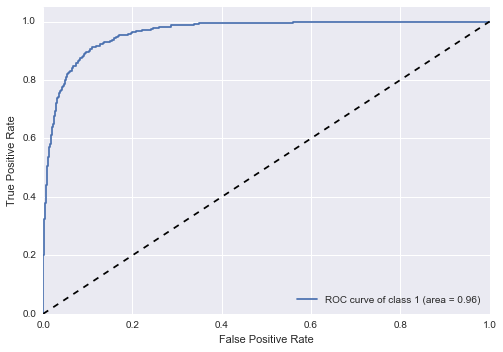


    Precision: 0.844
    Recall: 0.515
    F1: 0.640
    ROC: 0.963
    
time: 16.9 s


In [52]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration


    Precision: 0.844
    Recall: 0.515
    F1: 0.640
    ROC: 0.963
    


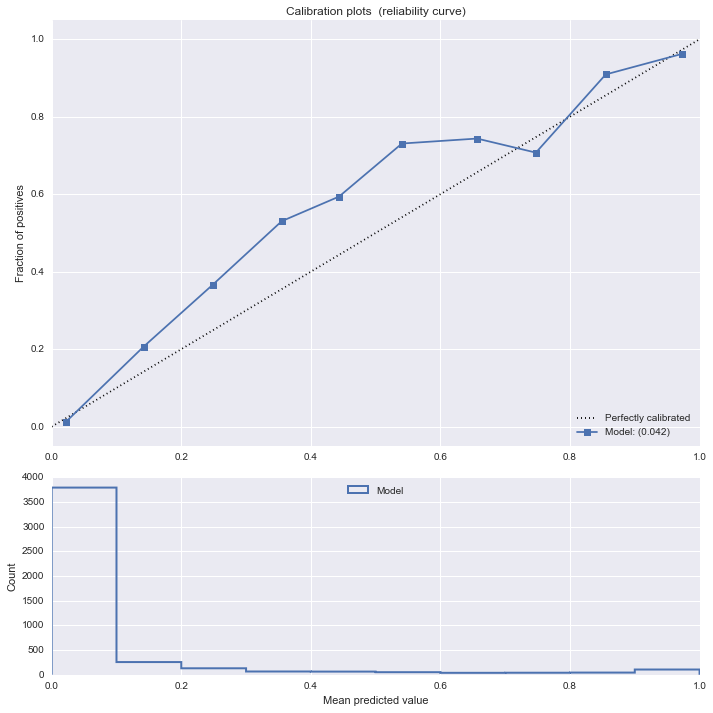

time: 16.9 s


In [53]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)


    Precision: 0.854
    Recall: 0.513
    F1: 0.641
    ROC: 0.946
    


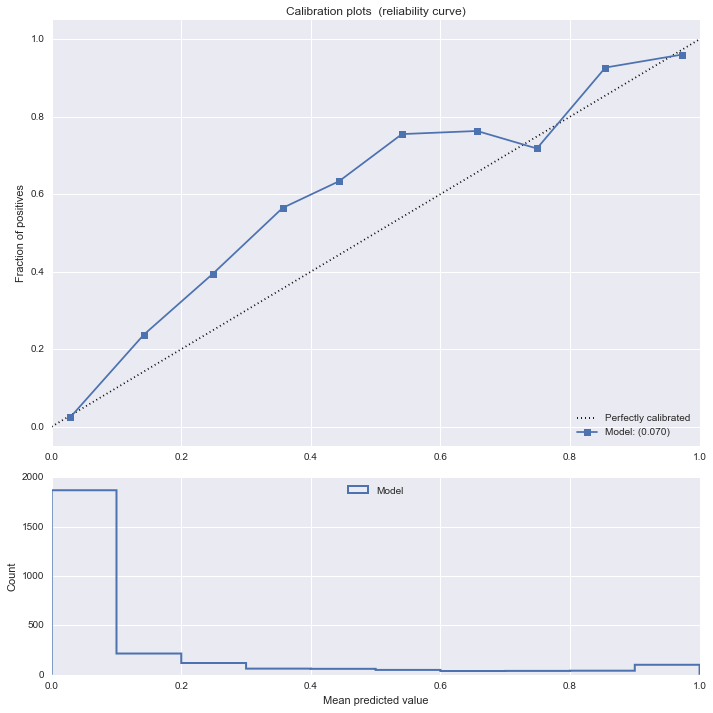

time: 10.2 s


In [55]:
_= eval_binary_classifier(br_model, b_test, calibration = True, roc = False)

### Error Analysis

In [24]:
fn, fp = get_clf_errors(br_model, br_test)

time: 18.9 s


In [25]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
" Please do not vandalize pages, as you did with this edit to Brian. If you continue to do so, you will be blocked from editing.    01:41, 7 May 2009 (UTC)"
SCORES: Actual: 1, Predicted: 0, Score: 0.02


COMMENT:
"Thanks Mackan, for the assist.  I am not sure I follow all points contested above; if anyone's wondering, no I did not find the oafishness or general vulgarity of mind displayed on that talk page to be lovable.  I am not particularly exercised about this, and though I think the block was illegitimate, I have no plan to pursue the matter further.  The only statement in this thread that I find objectionable is Shell's professed wish to see me ""take civility more seriously in the future.""  I ta
SCORES: Actual: 1, Predicted: 0, Score: 0.03


COMMENT:
" User Page deletion 19:05, 9 December 2008 Herbythyme (Talk | contribs) deleted ""User:Ssjgoku420"" ‎ (G3: Vandalism: offensive to me)Hi, you recently deleted my userpage, claiming that it was ""Vandalism"", but I think t

In [26]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
 stupid fuckin editors they should all go and fuck themselves
SCORES: Actual: 0, Predicted: 1, Score: 1.00


COMMENT:
I dont know who is retarded and stupid subsaharian asshole  
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
FUCK THA WORLD AND FUCK SINNEED AND FUCK FT2
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
Man, you are really a dishonest person, disgusting!!!!
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
Are you a faggot or what?
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
JzGWrong is still wrong, the circumstances don't matter. You won't be punished though because you are part of the admin. of this site now. You need to grow up, you fucking loser. I just called it how I saw it. It is a suicide and she will burn in hell for it. Also, You will never get rid of me, you and your deviant family have now become my personal project. I'm working on a website about your sister as we speak so everyone will know all about what a stupid 

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [27]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 1.33 ms


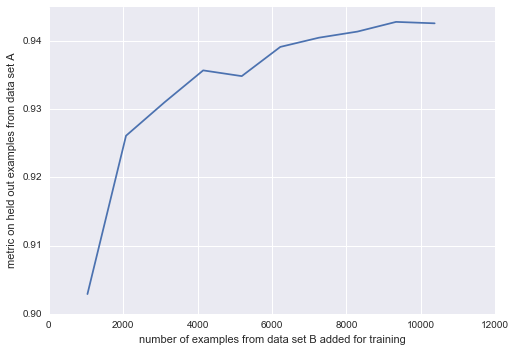

time: 5min 22s


In [28]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc, test_size = 0.5)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

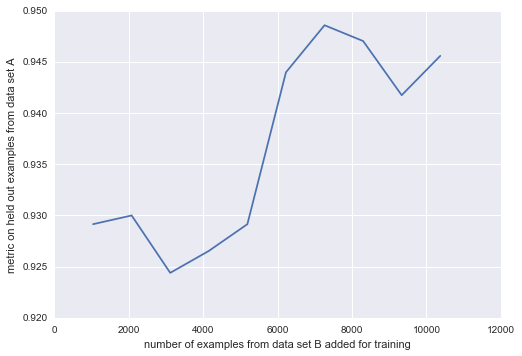

time: 26min 6s


In [29]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

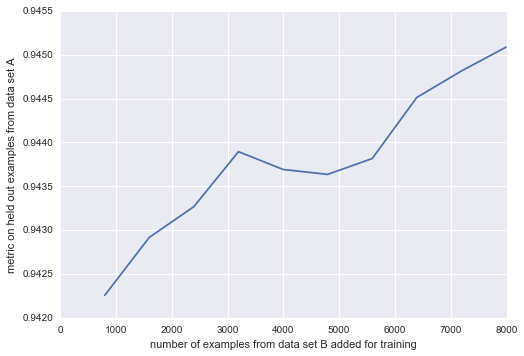

time: 23min 2s


In [30]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

# Final Model

In [56]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 2min 4s
